# CKD Emission Tutorial: ArtEmisPure with OpaCKD

Hajime Kawahara with Claude Code, July 1 (2025)

This tutorial demonstrates how to use the Correlated K-Distribution (CKD) method for atmospheric emission calculations with ExoJAX. 
The CKD method provides significant computational speedup by pre-computing opacity tables and using quadrature integration over g-ordinates.

## What is CKD?

Correlated K-Distribution (CKD) is a method that:
- Pre-computes opacity tables on temperature-pressure grids
- Groups spectral lines by absorption strength (k-distribution)
- Uses Gauss-Legendre quadrature to integrate over g-ordinates
- Provides band-averaged spectra with much faster computation

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from jax import config

# ExoJAX imports
from exojax.test.emulate_mdb import mock_mdbExomol, mock_wavenumber_grid
from exojax.opacity import OpaCKD, OpaPremodit
from exojax.rt import ArtEmisPure

# Enable 64-bit precision for accurate calculations
config.update("jax_enable_x64", True)

print("ExoJAX CKD Tutorial: Emission Spectroscopy")
print("===========================================")

ExoJAX CKD Tutorial: Emission Spectroscopy


## 1. Setup Atmospheric Model and Molecular Database

First, we'll set up our atmospheric model and molecular opacity database.

In [2]:
# Setup wavenumber grid and molecular database
nu_grid, wav, res = mock_wavenumber_grid()
print(f"Wavenumber grid: {len(nu_grid)} points from {nu_grid[0]:.1f} to {nu_grid[-1]:.1f} cm⁻¹")
print(f"Spectral resolution: {res:.1f}")

# Create mock H2O molecular database
mdb = mock_mdbExomol("H2O")
print(f"Molecular database: {mdb.nurange[0]:.1f} - {mdb.nurange[1]:.1f} cm⁻¹")

# Setup atmospheric radiative transfer
art = ArtEmisPure(
    pressure_top=1.0e-8, 
    pressure_btm=1.0e2, 
    nlayer=100, 
    nu_grid=nu_grid
)

print(f"Atmospheric layers: {art.nlayer}")
print(f"Pressure range: {art.pressure_top:.1e} - {art.pressure_btm:.1e} bar")

xsmode =  modit
xsmode assumes ESLOG in wavenumber space: xsmode=modit
Your wavelength grid is in ***  ascending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
Wavenumber grid: 20000 points from 4329.0 to 4363.0 cm⁻¹
Spectral resolution: 2556525.8
xsmode =  modit
xsmode assumes ESLOG in wavenumber space: xsmode=modit
Your wavelength grid is in ***  ascending  *** order
The wavenumber grid is in ascending order by definition.
Please be careful when you use the wavelength grid.
radis== 0.15.2
HITRAN exact name= H2(16O)
radis engine =  vaex


/home/kawahara/exojax/src/exojax/utils/grids.py:85: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/grids.py:85: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/grids.py:85: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/grids.py:85: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/database/api.py:134: UserWarning: The current version of radis does not support broadf_download (requires >=0.16).
  warnings.warn(msg, UserWarning)
/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning

Molecule:  H2O
Isotopologue:  1H2-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  H2O/1H2-16O/SAMPLE
Transition files: 
	 => File 1H2-16O__SAMPLE__04300-04400.trans
Broadener:  H2
Broadening code level: a1
DataFrame (self.df) available.
Molecular database: 4329.0 - 4363.0 cm⁻¹
rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)
Atmospheric layers: 100
Pressure range: 1.0e-08 - 1.0e+02 bar


## 2. Define Atmospheric Profile

We'll create a simple atmospheric profile with temperature and mixing ratio.

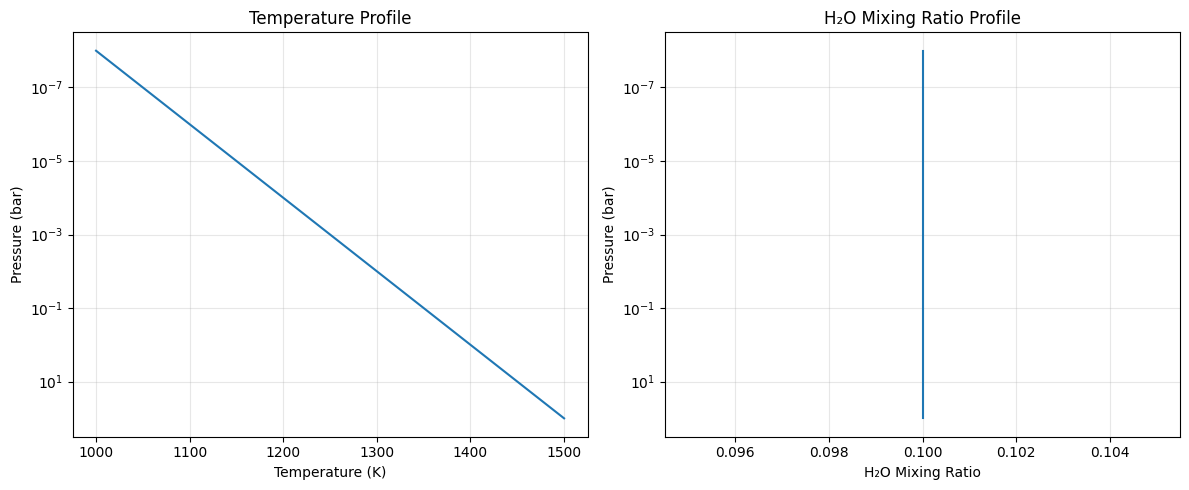

Temperature range: 1000 - 1500 K
H2O mixing ratio: 0.1 (constant)


In [3]:
# Create atmospheric temperature profile
Tarr = np.linspace(1000.0, 1500.0, 100)  # Linear temperature profile
mmr_arr = np.full(100, 0.1)  # Constant H2O mixing ratio
gravity = 2478.57  # Surface gravity (cm/s²)

# Plot atmospheric profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Temperature profile
ax1.semilogy(Tarr, art.pressure)
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Pressure (bar)')
ax1.set_title('Temperature Profile')
ax1.grid(True, alpha=0.3)
ax1.invert_yaxis()

# Mixing ratio profile
ax2.semilogy(mmr_arr, art.pressure)
ax2.set_xlabel('H₂O Mixing Ratio')
ax2.set_ylabel('Pressure (bar)')
ax2.set_title('H₂O Mixing Ratio Profile')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Temperature range: {np.min(Tarr):.0f} - {np.max(Tarr):.0f} K")
print(f"H2O mixing ratio: {mmr_arr[0]:.1f} (constant)")

## 3. Setup Standard Line-by-Line Opacity Calculator

First, we'll compute the standard high-resolution spectrum using line-by-line calculations.

In [7]:
# Initialize standard opacity calculator (Premodit)
base_opa = OpaPremodit(mdb, nu_grid, auto_trange=[500.0, 1500.0])

# Compute line-by-line cross-sections and emission spectrum
print("\nComputing line-by-line emission spectrum...")
xsmatrix = base_opa.xsmatrix(Tarr, art.pressure)
dtau = art.opacity_profile_xs(xsmatrix, mmr_arr, base_opa.mdb.molmass, gravity)
F0_lbl = art.run(dtau, Tarr)

print(f"Line-by-line spectrum computed!")

OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1514.171191195336 K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K
max value of  ngamma_ref_grid : 25.22068521876662
min value of  ngamma_ref_grid : 14.029708313440466
ngamma_ref_grid grid : [14.02970695 16.24522392 18.81060491 21.78110064 25.22068787]
max value of  n_Texp_grid : 0.541
min value of  n_Texp_grid : 0.216
n_Texp_grid grid : [0.21599999 0.3785     0.54100007]


uniqidx: 100%|██████████| 4/4 [00:00<00:00, 19021.79it/s]

Premodit: Twt= 1108.7151960064205 K Tref= 570.4914318566549 K
Making LSD:|####################| 100%

Computing line-by-line emission spectrum...
Line-by-line spectrum computed!


## 4. Setup CKD Opacity Calculator

Now we'll initialize the CKD opacity calculator and pre-compute the opacity tables.

In [8]:
# Initialize CKD opacity calculator
opa_ckd = OpaCKD(
    base_opa,           # Base opacity calculator
    Ng=32,              # Number of g-ordinates for quadrature
    band_width=0.5      # Spectral band width
)

print(f"CKD Opacity Calculator Setup:")
print(f"  Number of g-ordinates (Ng): {opa_ckd.Ng}")
print(f"  Band width: {opa_ckd.band_width}")
print(f"  Number of spectral bands: {len(opa_ckd.nu_bands)}")
print(f"  Spectral range: {opa_ckd.nu_bands[0]:.1f} - {opa_ckd.nu_bands[-1]:.1f} cm⁻¹")

# Pre-compute CKD tables on temperature-pressure grid
print("\nPre-computing CKD tables...")
NTgrid = 10
NPgrid = 10
T_grid = np.linspace(np.min(Tarr), np.max(Tarr), NTgrid)
P_grid = np.logspace(
    np.log10(np.min(art.pressure)),
    np.log10(np.max(art.pressure)),
    NPgrid,
)

opa_ckd.precompute_tables(T_grid, P_grid)

print(f"CKD tables computed on {NTgrid}×{NPgrid} T-P grid")
print(f"Temperature grid: {T_grid[0]:.0f} - {T_grid[-1]:.0f} K")
print(f"Pressure grid: {P_grid[0]:.1e} - {P_grid[-1]:.1e} bar")

CKD Opacity Calculator Setup:
  Number of g-ordinates (Ng): 32
  Band width: 0.5
  Number of spectral bands: 68
  Spectral range: 4329.3 - 4362.8 cm⁻¹

Pre-computing CKD tables...
Generated g-grid: 32 points, range [0.0014, 0.9986]
Processing 68 spectral bands...
  Band 1: [4329.0, 4329.5] cm⁻¹, 295 frequencies
  Band 2: [4329.5, 4330.0] cm⁻¹, 294 frequencies
  Band 3: [4330.0, 4330.5] cm⁻¹, 294 frequencies
  Band 4: [4330.5, 4331.0] cm⁻¹, 294 frequencies
  Band 5: [4331.0, 4331.5] cm⁻¹, 294 frequencies
  Band 6: [4331.5, 4332.0] cm⁻¹, 294 frequencies
  Band 7: [4332.0, 4332.5] cm⁻¹, 294 frequencies
  Band 8: [4332.5, 4333.0] cm⁻¹, 294 frequencies
  Band 9: [4333.0, 4333.5] cm⁻¹, 294 frequencies
  Band 10: [4333.5, 4334.0] cm⁻¹, 295 frequencies
  Band 11: [4334.0, 4334.5] cm⁻¹, 294 frequencies
  Band 12: [4334.5, 4335.0] cm⁻¹, 294 frequencies
  Band 13: [4335.0, 4335.5] cm⁻¹, 294 frequencies
  Band 14: [4335.5, 4336.0] cm⁻¹, 294 frequencies
  Band 15: [4336.0, 4336.5] cm⁻¹, 294 frequen

## 5. Compute CKD Emission Spectrum

Now we'll compute the emission spectrum using the CKD method.

In [9]:
# Get CKD cross-section tensor and compute CKD spectrum
print("Computing CKD emission spectrum...")
xs_ckd = opa_ckd.xstensor_ckd(Tarr, art.pressure)
dtau_ckd = art.opacity_profile_xs_ckd(
    xs_ckd, mmr_arr, base_opa.mdb.molmass, gravity
)

print(f"CKD optical depth tensor shape: {dtau_ckd.shape}")
print(f"  Layers: {dtau_ckd.shape[0]}")
print(f"  G-ordinates: {dtau_ckd.shape[1]}")
print(f"  Spectral bands: {dtau_ckd.shape[2]}")

# Run CKD emission calculation
F0_ckd = art.run_ckd(
    dtau_ckd, Tarr, opa_ckd.ckd_info.weights, opa_ckd.nu_bands
)

print(f"\nCKD spectrum computed!")
print(f"CKD flux shape: {F0_ckd.shape}")
print(f"CKD flux range: [{np.min(F0_ckd):.2e}, {np.max(F0_ckd):.2e}] erg/s/cm²/Hz")

Computing CKD emission spectrum...
CKD optical depth tensor shape: (100, 32, 68)
  Layers: 100
  G-ordinates: 32
  Spectral bands: 68

CKD spectrum computed!
CKD flux shape: (68,)
CKD flux range: [2.61e+04, 3.53e+04] erg/s/cm²/Hz


## 6. Compute Reference Band Averages

To validate the CKD results, we'll compute reference band averages from the line-by-line spectrum.

In [10]:
# Compute reference band averages by direct integration
print("Computing reference band averages...")
flux_average_reference = []
band_edges = opa_ckd.band_edges

for band_idx in range(len(opa_ckd.nu_bands)):
    # Create mask for frequencies within this band
    mask = (band_edges[band_idx, 0] <= nu_grid) & (
        nu_grid < band_edges[band_idx, 1]
    )
    # Arithmetic average over the band
    flux_average_reference.append(np.mean(F0_lbl[mask]))

flux_average_reference = np.array(flux_average_reference)

print(f"Reference band averages computed for {len(flux_average_reference)} bands")

Computing reference band averages...
Reference band averages computed for 68 bands


## 7. Compare Results and Validate Accuracy

Let's compare the CKD results with both the high-resolution line-by-line spectrum and the reference band averages.

In [11]:
# Calculate accuracy metrics
res = np.sqrt(np.sum((F0_ckd - flux_average_reference)**2)/len(F0_ckd))/np.mean(flux_average_reference)
max_relative_error = np.max(np.abs((F0_ckd - flux_average_reference) / flux_average_reference))
mean_relative_error = np.mean(np.abs((F0_ckd - flux_average_reference) / flux_average_reference))

print(f"CKD Accuracy Assessment:")
print(f"  RMS relative error: {res:.4f}")
print(f"  Maximum relative error: {max_relative_error:.4f}")
print(f"  Mean relative error: {mean_relative_error:.4f}")

# Calculate spectral resolution
resolution = opa_ckd.nu_bands[0]/(band_edges[0, 1] - band_edges[0, 0])
print(f"  Effective resolution: {resolution:.1f}")

# Check if accuracy meets typical requirements
accuracy_threshold = 0.05  # 5% error threshold
if res < accuracy_threshold:
    print(f"✓ CKD accuracy meets requirement (< {accuracy_threshold:.1%})")
else:
    print(f"⚠ CKD error exceeds threshold ({accuracy_threshold:.1%})")

CKD Accuracy Assessment:
  RMS relative error: 0.0009
  Maximum relative error: 0.0018
  Mean relative error: 0.0008
  Effective resolution: 8692.6
✓ CKD accuracy meets requirement (< 5.0%)


## 8. Visualize Results

Finally, let's create a comprehensive comparison plot showing all three spectra.

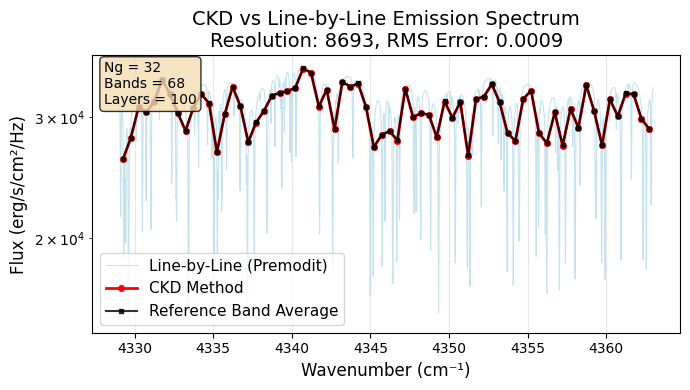

Figure saved as: ckd_emission_comparison_res8693.png


<Figure size 640x480 with 0 Axes>

In [13]:
# Create comparison plot
plt.figure(figsize=(7, 4))

# Plot line-by-line spectrum (high resolution)
plt.plot(nu_grid, F0_lbl, 
         label="Line-by-Line (Premodit)", 
         alpha=0.7, linewidth=0.8, color='lightblue')

# Plot CKD spectrum
plt.plot(opa_ckd.nu_bands, F0_ckd, 
         'o-', label="CKD Method", 
         markersize=4, linewidth=2, color='red')

# Plot reference band averages
plt.plot(opa_ckd.nu_bands, flux_average_reference, 
         's-', label="Reference Band Average", 
         markersize=3, linewidth=1.5, color='black', alpha=0.8)

plt.xlabel('Wavenumber (cm⁻¹)', fontsize=12)
plt.ylabel('Flux (erg/s/cm²/Hz)', fontsize=12)
plt.title(f'CKD vs Line-by-Line Emission Spectrum\n'
          f'Resolution: {resolution:.0f}, RMS Error: {res:.4f}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Add text box with key parameters
textstr = f'Ng = {opa_ckd.Ng}\nBands = {len(opa_ckd.nu_bands)}\nLayers = {art.nlayer}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig(f"ckd_emission_comparison_res{resolution:.0f}.png", 
            dpi=300, bbox_inches='tight')
print(f"Figure saved as: ckd_emission_comparison_res{resolution:.0f}.png")

## 9. Performance Comparison

Let's demonstrate the computational speedup achieved by the CKD method.

In [14]:
import time

# Time line-by-line calculation
start_time = time.time()
for _ in range(5):  # Multiple runs for better timing
    xsmatrix = base_opa.xsmatrix(Tarr, art.pressure)
    dtau = art.opacity_profile_xs(xsmatrix, mmr_arr, base_opa.mdb.molmass, gravity)
    F0_lbl_timing = art.run(dtau, Tarr)
lbl_time = (time.time() - start_time) / 5

# Time CKD calculation (excluding table pre-computation)
start_time = time.time()
for _ in range(5):
    xs_ckd = opa_ckd.xstensor_ckd(Tarr, art.pressure)
    dtau_ckd = art.opacity_profile_xs_ckd(xs_ckd, mmr_arr, base_opa.mdb.molmass, gravity)
    F0_ckd_timing = art.run_ckd(dtau_ckd, Tarr, opa_ckd.ckd_info.weights, opa_ckd.nu_bands)
ckd_time = (time.time() - start_time) / 5

speedup = lbl_time / ckd_time

print(f"Performance Comparison:")
print(f"  Line-by-Line time: {lbl_time:.3f} seconds")
print(f"  CKD time: {ckd_time:.3f} seconds")
print(f"  Speedup factor: {speedup:.1f}×")
print(f"  Spectral points: {len(nu_grid)} → {len(opa_ckd.nu_bands)} ({len(opa_ckd.nu_bands)/len(nu_grid):.1%})")

Performance Comparison:
  Line-by-Line time: 0.130 seconds
  CKD time: 0.075 seconds
  Speedup factor: 1.7×
  Spectral points: 20000 → 68 (0.3%)


## Summary

This tutorial demonstrated how to use the CKD method with ExoJAX for emission spectroscopy:

### Key Steps:
1. **Setup**: Initialize atmospheric model and molecular database
2. **Profile**: Define temperature and mixing ratio profiles  
3. **Line-by-Line**: Compute high-resolution reference spectrum
4. **CKD Setup**: Initialize CKD calculator and pre-compute tables
5. **CKD Calculation**: Compute band-averaged spectrum using CKD
6. **Validation**: Compare CKD results with reference data
7. **Visualization**: Plot comparison and analyze accuracy

